# **ASAH (Aplikasi Sortir Sampah)**

Ini merupakan repository untuk pembuatan model machine learning klasifikasi gambar sampah untuk proyek akhir Bangkit Academy 2023.

Anggota Machine Learning:
- Edwin Mahendra
- Johannes Baptista Adiatmaja Pambudi

# **Import Library**

Diperlukan import library berikut untuk mengerjakan proyek ini.

In [2]:
import os
import shutil
import zipfile
import pathlib
import random

import cv2

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

Cek versi tensorflow

In [3]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.12.0


# **Dataset Preparation**

Dataset yang digunakan adalah dataset Garbage Classification yang memuat 12 jenis sampah. Dataset ini diperoleh dari kaggle dengan link: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edwinmahendraa","key":"bac357079ce9ef39f03d76d95ad91ce4"}'}

In [6]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [7]:
!kaggle datasets download -d mostafaabla/garbage-classification

 89% 213M/239M [00:01<00:00, 169MB/s]
100% 239M/239M [00:01<00:00, 191MB/s]


In [8]:
local_zip = 'garbage-classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [9]:
PATH = '/content/garbage_classification'

# **Explore Dataset**

Total images from this dataset: 15515

Distribution of Images:
1. metal : 769
2. shoes : 1977
3. battery : 945
4. white-glass : 775
5. clothes : 5325
6. paper : 1050
7. brown-glass : 607
8. cardboard : 891
9. trash : 697
10. biological : 985
11. green-glass : 629
12. plastic : 865



========== Bar Graph ==========


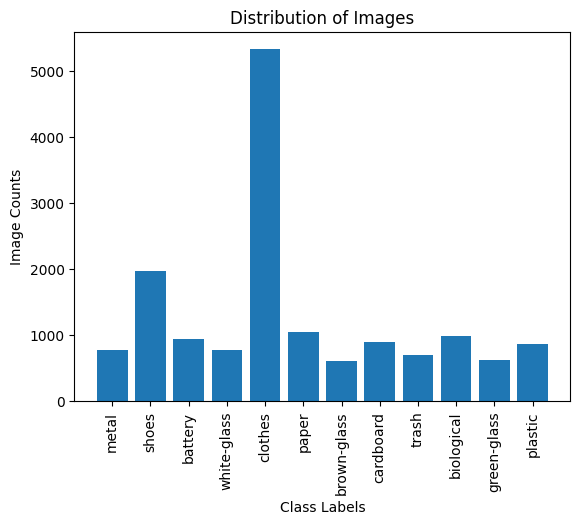

In [10]:
PATH = '/content/garbage_classification'
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total images from this dataset: {image_count}')

class_labels = []
class_counts = []

print('\nDistribution of Images:')
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')
    class_labels.append(label)
    class_counts.append(len_label_dir)

print('\n\n')
print('========== Bar Graph ==========')
# Create a bar graph
plt.bar(class_labels, class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Image Counts')
plt.title('Distribution of Images')
plt.xticks(rotation=90)
plt.show()

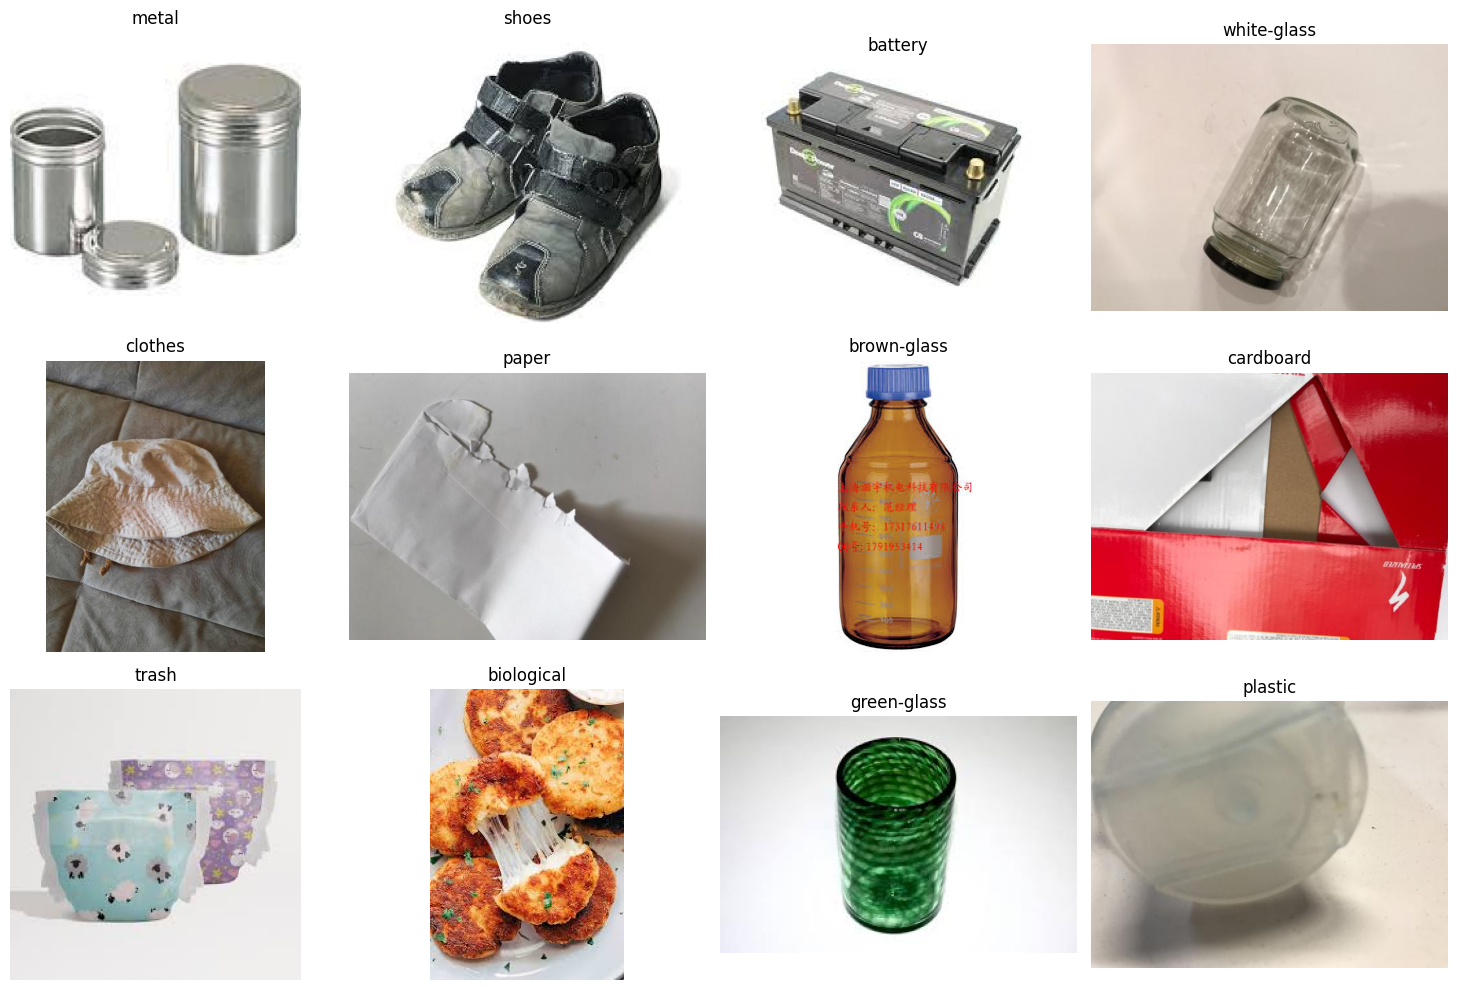

In [11]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, label in enumerate(class_labels):
    label_dir = os.path.join(data_dir, label)
    image_files = os.listdir(label_dir)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(label_dir, random_image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# **Data Preprocessing & Transformation**

**Set Up Parameter**

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


**Divide Data into Train and Validation Test**

Proses selanjutnya adalah pembagian Dataset. Dataset akan dibagi menjadi train dan validation test. Data train atau latih akan digunakan untuk membangun model, sedangkan data validation dan test akan digunakan untuk menguji performa model. Pada proyek ini dataset sebesar 15.515 data gambar akan dibagi menjadi 80% (Train Set Data) dan 20% (Validation Set Data).

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [14]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

**Test Data**

Membagi validation set data untuk menghasilkan test data

In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 78
Number of test batches: 19


**Data Performance**

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Build a Model**



In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomZoom(0.2)],
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

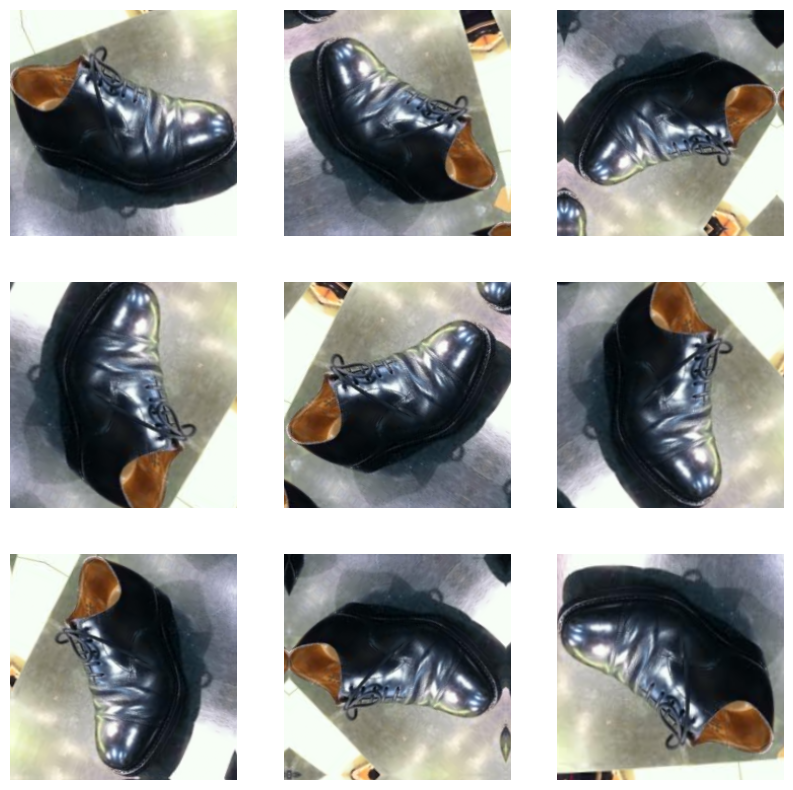

In [18]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes, 
                                  activation='softmax', 
                                  name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

In [21]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

# **Model Training**

In [22]:
model = model_builder()
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
388/388 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.8290
Epoch 1: val_accuracy improved from -inf to 0.89259, saving model to checkpoint_model.h5
388/388 [==============================] - 42s 76ms/step - loss: 0.5484 - accuracy: 0.8290 - val_loss: 0.3413 - val_accuracy: 0.8926
Epoch 2/100
387/388 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8851
Epoch 2: val_accuracy improved from 0.89259 to 0.90822, saving model to checkpoint_model.h5
388/388 [==============================] - 21s 53ms/step - loss: 0.3566 - accuracy: 0.8850 - val_loss: 0.2730 - val_accuracy: 0.9082
Epoch 3/100
388/388 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8986
Epoch 3: val_accuracy did not improve from 0.90822
388/388 [==============================] - 20s 52ms/step - loss: 0.3041 - accuracy: 0.8986 - val_loss: 0.2927 - val_accuracy: 0.9070
Epoch 4/100
388/388 [==============================] - ETA: 0s - loss: 0.2727 

# **Accuracy and Plot Lost Graph Model MobileNetV2**

In [23]:
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-23-447fa776aed2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


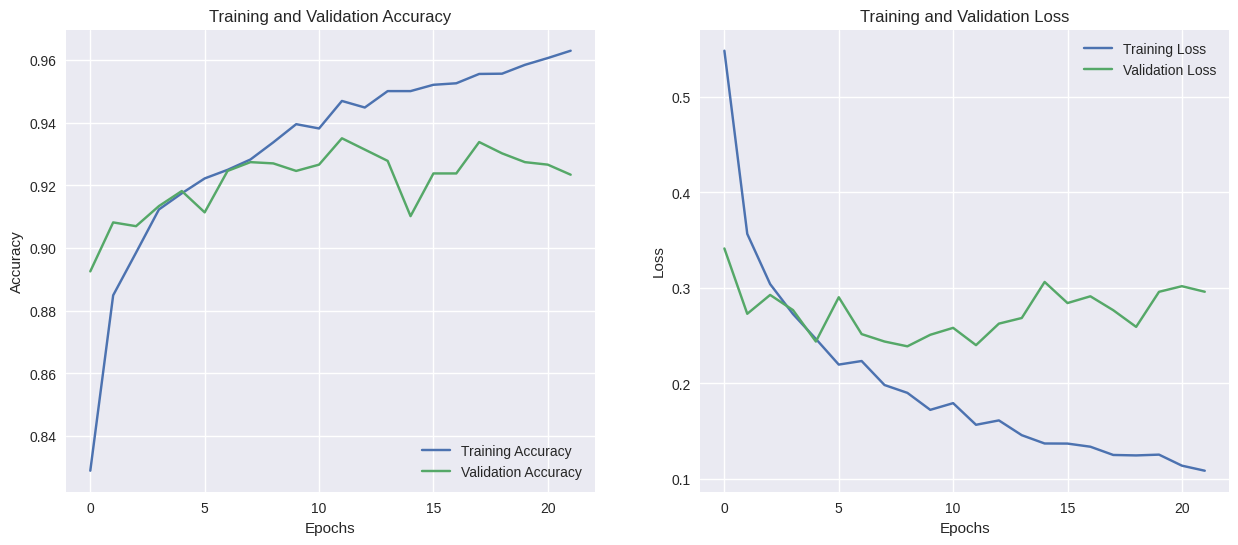

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Evaluating Model**

In [25]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

19/19 [==============================] - 4s 80ms/step - loss: 0.2174 - accuracy: 0.9375


{'loss': 0.21736393868923187, 'accuracy': 0.9375}

# **Testing Model**

In [26]:
class_names = np.array(class_names)
class_names_val = np.array(class_names_val)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

List label Train data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']

List label Validation data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']
1/1 [==============================] - 1s 1s/step
['paper' 'shoes' 'metal' 'clothes' 'biological' 'clothes' 'clothes'
 'white-glass' 'cardboard' 'clothes' 'biological' 'clothes' 'clothes'
 'white-glass' 'shoes' 'clothes' 'biological' 'paper' 'clothes' 'shoes'
 'green-glass' 'clothes' 'shoes' 'clothes' 'clothes' 'plastic' 'clothes'
 'metal' 'plastic' 'clothes' 'shoes' 'plastic']


In [27]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
  if i in label_batch_test:
    true_predict +=1
  else:
    false_predict +=1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[ 7  9  6  4  1  4  4 11  3  4  1  4  4 11  9  4  1  7  4  9  5  4  9  4
  4  8  4  6  8  4  9  8]
Predicted labels:
[ 7  9  6  4  1  4  4 11  3  4  1  4  4 11  9  4  1  7  4  9  5  4  9  4
  4  8  4  6  8  4  9  8]

True Predict Count : 32
False Predict Count : 0


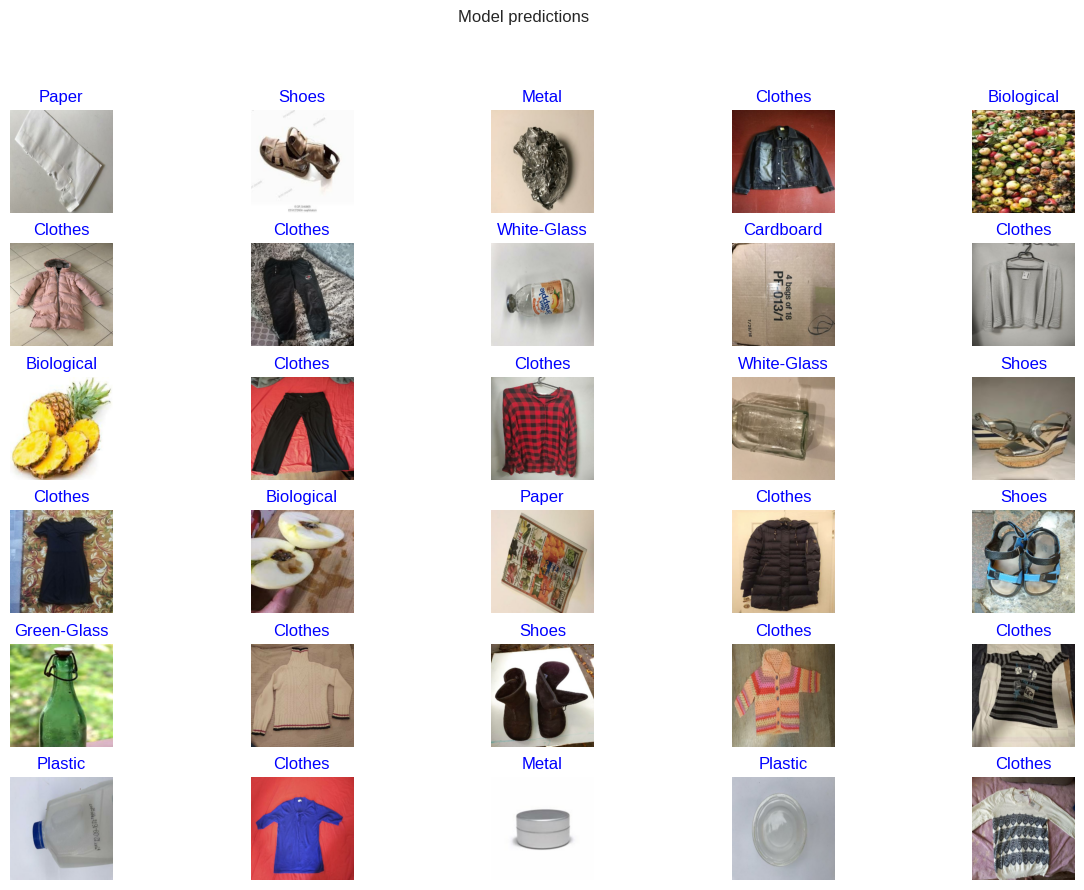

In [28]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Saving WhatsApp Image 2023-05-17 at 21.18.45.jpeg to WhatsApp Image 2023-05-17 at 21.18.45 (5).jpeg
1/1 [==============================] - 0s 24ms/step


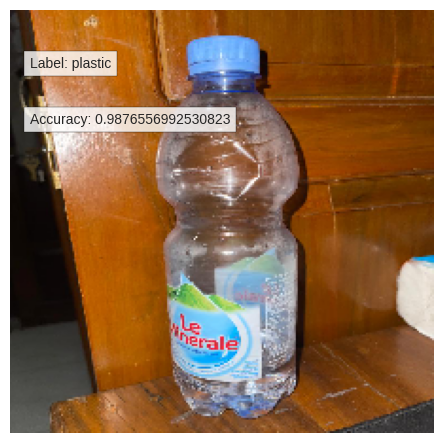

In [35]:
uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=IMG_SIZE + (3,))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = load_model.predict(images, batch_size=10)
    outclass = np.argmax(classes)

    plt.imshow(img)
    plt.axis('off')
    plt.text(10, 30, f'Label: {class_names[outclass]}', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(10, 60, f'Accuracy: {classes[0][outclass]}', bbox=dict(facecolor='white', alpha=0.8))
    plt.show()